In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

import matplotlib.animation as animation


In [3]:
def BoltzmannWeight_local(spins, sitex, sitey, K, h, T, dop_spacing):
  sum=0

  K_dop_val=2*K/T
  K_reg_val=1*K/T
    #assumes non periodic boundary conditions, should be fine to ignore in the large N limit
  if sitex % dop_spacing ==0 and sitey % dop_spacing ==0:
    K=K_dop_val
  else:
    K=K_reg_val
  if sitex == (len(spins)-1)  and sitey != len(spins)-1  and sitey !=0:
    #sum+=((K*spins[sitex][sitey]*spins[sitex+1][sitey]))
    sum+=((K*spins[sitex][sitey]*spins[sitex-1][sitey]))
    sum+=((K*spins[sitex][sitey]*spins[sitex][sitey+1]))
    sum+=((K*spins[sitex][sitey]*spins[sitex][sitey-1]))
  if sitey == len(spins)-1  and sitex != len(spins)-1 and sitex !=0:
    sum+=((K*spins[sitex][sitey]*spins[sitex+1][sitey]))
    sum+=((K*spins[sitex][sitey]*spins[sitex-1][sitey]))
    #sum+=((K*spins[sitex][sitey]*spins[sitex][sitey+1]))
    sum+=((K*spins[sitex][sitey]*spins[sitex][sitey-1]))
  if sitex ==0  and sitey != len(spins)-1 and sitey !=0:
    sum+=((K*spins[sitex][sitey]*spins[sitex+1][sitey]))
    #sum+=((K*spins[sitex][sitey]*spins[sitex-1][sitey]))
    sum+=((K*spins[sitex][sitey]*spins[sitex][sitey+1]))
    sum+=((K*spins[sitex][sitey]*spins[sitex][sitey-1]))
  if sitey==0 and sitex != len(spins)-1 and sitex !=0:
    sum+=((K*spins[sitex][sitey]*spins[sitex+1][sitey]))
    sum+=((K*spins[sitex][sitey]*spins[sitex-1][sitey]))
    sum+=((K*spins[sitex][sitey]*spins[sitex][sitey+1]))
    #sum+=((K*spins[sitex][sitey]*spins[sitex][sitey-1]))
  if sitex != len(spins)-1 and sitey != len(spins)-1 and sitex !=0 and sitey !=0:
    sum+=((K*spins[sitex][sitey]*spins[sitex+1][sitey]))
    sum+=((K*spins[sitex][sitey]*spins[sitex-1][sitey]))
    sum+=((K*spins[sitex][sitey]*spins[sitex][sitey+1]))
    sum+=((K*spins[sitex][sitey]*spins[sitex][sitey-1]))

  sum+=((h*spins[sitex][sitey]))
            #print(sum)
    #print(sum)
  BW=np.exp(sum)
  return BW



In [4]:
def genSamples_hits_dopants(N_lattice, num_samples, K, h, T, dop_spacing, E_in, hit_time):
    # number of sites in our 1D ising model
    #N_lattice = 12
    
    samples = np.zeros([num_samples, N_lattice, N_lattice]) # where you will store your samples

    for i in range((num_samples)):
      if i==0:
        #creat the lattice at "time step 1"
        spin_start= np.ones([N_lattice, N_lattice])
        #pos_flip=np.zeros([N_lattice, N_lattice])
        #spin_start= np.random.choice([-1,1], [N_lattice, N_lattice]) #starting arbitrary set of spins
        #spin_start= np.zeros([N_lattice, N_lattice])
      #pick random site
        samples[0]= spin_start
      if i>0:
        #samples[i]=samples[i-1]
        spin_start= samples[i-1].copy()
        #print(i, samples[i-1]-samples[i-2])
      if i==hit_time: #put the particle hit at time step hit_time
        #samples[i]=spin_start
        spin_start= samples[i-1].copy()
        #print(i, samples[i-1]-samples[i-2])
        hit_sitex=int(N_lattice/2)
        hit_sitey=int(N_lattice/2)
        spin_start[hit_sitex, hit_sitey]= -1
        for s_x in range(int(np.sqrt(E_in))+1): #s is number of particles ionized
          for s_y in range(int(np.sqrt(E_in))+1):
            spin_start[hit_sitex+s_x, hit_sitey+s_y] = -1
            

        samples[i]=spin_start
      # if i>=1:
      #   nearest_neightbors= [[hit_sitex+1, hit_sitey],[hit_sitex, hit_sitey+1],[hit_sitex-1, hit_sitey],[hit_sitex, hit_sitey-1]]
      #   pos_flip_nn=spin_start.copy()
      #   for j in range(len(nearest_neightbors)):
      #     #print('nearest', nearest_neightbors[j])
      #     #spin_start= samples[i-1].copy()
      #     pos_flip_nn[nearest_neightbors[j]]=-1*spin_start.copy()[nearest_neightbors[j]]
      #     A= BoltzmannWeight_local(pos_flip_nn, nearest_neightbors[j][0], nearest_neightbors[j][1], K, h, T, dop_spacing)/BoltzmannWeight_local(spin_start, nearest_neightbors[j][0], nearest_neightbors[j][1], K, h, T, dop_spacing)
      #     A=np.min([1,A])
      #     prob_prop =np.random.rand(1,1)
      #     if prob_prop <=A:
      #     #print(samples[i]-pos_flip)
      #       samples[i] = pos_flip_nn.copy()
      #       print('flip', i)
      #     else:
      #       samples[i]=spin_start.copy()
      #       print('no flip', i)

      for n in range(N_lattice): #number of possible flips
        #spin_start= samples[i]

        site= np.random.choice(N_lattice), np.random.choice(N_lattice)
        if i==hit_time and site== (hit_sitex, hit_sitey):
          site= np.random.choice(N_lattice), np.random.choice(N_lattice)
        #print(i, spin_start[site])
        #define the flipped spin_start
        pos_flip=spin_start.copy()
        #print(pos_flip[site])
        if pos_flip[site]==1:
          pos_flip[site]=-1
        else:
          pos_flip[site]=1
        #pos_flip[site]=-1*spin_start.copy()[site]

        #determine probability of flip - random num gen >A dont flip, random num gen < A, flip
        A= BoltzmannWeight_local(pos_flip, site[0], site[1], K, h, T, dop_spacing)/BoltzmannWeight_local(spin_start, site[0], site[1], K, h, T, dop_spacing)
        A=np.min([1,A])
        #print(A, BoltzmannWeight_dopants(pos_flip, K, h, T, dop_spacing), BoltzmannWeight_dopants(spin_start, K, h, T, dop_spacing))
        #print(n, A)
        prob =np.random.rand(1,1)
        noise_prob=0.01*T #noise increases as temperature increases


        #print(prob, noise_prob, A
        #print(prob, noise_prob, A)
        #print(prob)
        if prob <=A:
          #print(samples[i]-pos_flip)
          #print(pos_flip[site]-spin_start[site])
          spin_start = pos_flip
          #print(i, n, A, site, 'flip')
          #print(pos_flip-spin_start)
          #print(pos_flip[site]-spin_start[site])
          #print(BoltzmannWeight_local(pos_flip, site[0], site[1], K, h, T, dop_spacing), BoltzmannWeight_local(spin_start, site[0], site[1], K, h, T, dop_spacing))

        # if prob<=noise_prob and prob>A: #there is a nonzero chance of a flip even if it is not energetically favorable
        #   #print(samples[i]-pos_flip)
        #   spin_start = pos_flip
        #   #print(A, 'noise')
      # store the choice in samples
        else:
          spin_start =spin_start
          #print(A, prob, 'no flip')
      samples[i]=spin_start
    return samples

In [15]:
#temp=np.linspace(1,1.5,10)
N_lattice = 100


n_samp=600
K=1
T=1
hit_time=n_samp-100
E_hit=6

test_dop_hits= genSamples_hits_dopants(N_lattice,n_samp, K, 1, T, 5, E_hit, hit_time)

#print(len(test_dop_hits))

Text(0.5, 1.0, 'Lattice Size 100x100, hit energy 6, number of runs per temp 100 ')

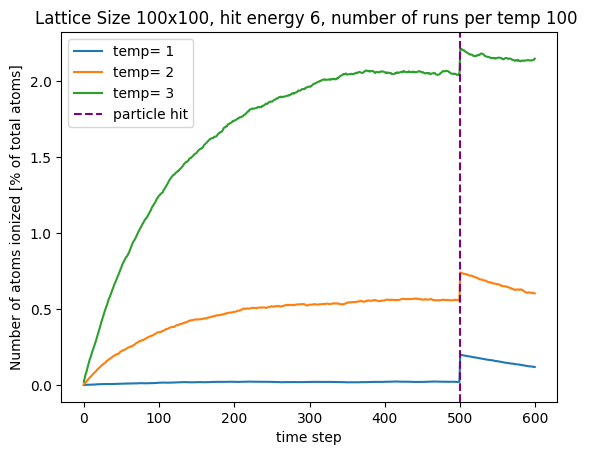

In [23]:
def magnetization(spins_array):
    mag_vals = np.zeros(len(spins_array))
    tot_sites= N_lattice**2
    for i in range(len(spins_array)):
        mag_vals[i] = np.sum(spins_array[i])
    
    return np.abs((mag_vals-tot_sites)/tot_sites)*100


times=np.arange(0, len(test_dop_hits))
temps= [1,2,3]
num_runs= 100


for t in temps: 
    mag= np.zeros([num_runs, n_samp])
    magnet=np.zeros(n_samp)
    for r in range(num_runs):
        test_dop_hits= genSamples_hits_dopants(N_lattice,n_samp, K, 1, t, 5, E_hit, hit_time)
        #print(len(magnetization(test_dop_hits)))
        mag[r,]= magnetization(test_dop_hits) 
        #print(mag)
    
        magnet+=mag[r]
    magnet=magnet/num_runs
    #print(magnet)
    plt.plot(times, magnet, label=f"temp= {t}")


plt.xlabel('time step')
plt.ylabel('Number of atoms ionized [% of total atoms]')
plt.axvline(hit_time, 0, mag.max(), label="particle hit", color='purple', linestyle='--')
plt.legend()
plt.title(f"Lattice Size {N_lattice}x{N_lattice}, hit energy {E_hit}, number of runs per temp {num_runs} ")




In [24]:
N_lattice=100
n_samp=200
hit_time=n_samp-100
test_dop_hits= genSamples_hits_dopants(N_lattice,n_samp, K, 1, T, 5, E_hit, hit_time)

from matplotlib.animation import FuncAnimation
fig, ax = plt.subplots(figsize=(N_lattice, N_lattice))
ax.set(xlim=(0,N_lattice ), ylim=(0, N_lattice))

cax = ax.pcolormesh(test_dop_hits[0],vmin=-2, vmax=1, cmap=plt.cm.Blues)
fig.colorbar(cax)
#plt.show()


def animate(i):
     cax.set_array(test_dop_hits[i].flatten())
     

     #print(i)
     #ax.text(0.05, 0.95, f'Time step: {i}', transform=ax.transAxes, va='top')
     #plt.suptitle(i)
     #cbar.set_title(f'Frame {i}')
     #ax.clear()
     if i==hit_time:
          ax.set_title(f"time = {i}, temp= {T}, hit, hit energy= {E_hit}", fontsize=60)
     else:
          ax.set_title(f"time = {i}, temp= {T}", fontsize=60)
          
     #ttl = ax.text(0.5, 1.005, i, transform = ax.transAxes, va='center', fontsize= 'medium')
     return cax


anim = FuncAnimation(fig, animate, interval=400, frames=(n_samp))

#plt.show()
#anim.save('test.mp4')
#anim.save('test.gif', writer='imagemagick')
anim.save('Ising_model_detector_100N_200samp.gif', writer = "pillow", fps=5 )

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (100000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
